**First we load and merge train, val and test datasets**

In [1]:
import pandas as pd

# 1. Load Training Data
train_args = pd.read_csv("data/arguments-training.tsv", sep='\t')
train_labels = pd.read_csv("data/labels-training.tsv", sep='\t')
df_train = pd.merge(train_args, train_labels, on="Argument ID")

# 2. Load Validation Data
val_args = pd.read_csv("data/arguments-validation.tsv", sep='\t')
val_labels = pd.read_csv("data/labels-validation.tsv", sep='\t')
df_val = pd.merge(val_args, val_labels, on="Argument ID")

# 3. Load Test Data (Crucial for volume!)
test_args = pd.read_csv("data/arguments-test.tsv", sep='\t')
test_labels = pd.read_csv("data/labels-test.tsv", sep='\t')
df_test = pd.merge(test_args, test_labels, on="Argument ID")

# 4. Concatenate EVERYTHING into one giant dataset
trainval_df = pd.concat([df_train, df_val, df_test], ignore_index=True)

# 5. Verify the size (Should be > 8,500)
print(f"Total Examples: {len(trainval_df)}")
print(trainval_df.head(3))

Total Examples: 8865
  Argument ID                                   Conclusion       Stance  \
0      A01002                  We should ban human cloning  in favor of   
1      A01005                      We should ban fast food  in favor of   
2      A01006  We should end the use of economic sanctions      against   

                                             Premise  Self-direction: thought  \
0  we should ban human cloning as it will only ca...                        0   
1  fast food should be banned because it is reall...                        0   
2  sometimes economic sanctions are the only thin...                        0   

   Self-direction: action  Stimulation  Hedonism  Achievement  \
0                       0            0         0            0   
1                       0            0         0            0   
2                       0            0         0            0   

   Power: dominance  ...  Tradition  Conformity: rules  \
0                 0  ...          

**Examples**

In [2]:
import pandas as pd

# 1. Load the Data
# Using validation set because it's cleaner for inspection
df_args = pd.read_csv("data/arguments-validation.tsv", sep='\t')
df_labels = pd.read_csv("data/labels-validation.tsv", sep='\t')

# 2. Merge them
val_df = pd.merge(df_args, df_labels, on="Argument ID")

# 3. Identify the Value Columns (The 19 or 20 labels)
# We exclude the text columns to find just the label columns
metadata_cols = ['Argument ID', 'Conclusion', 'Stance', 'Premise', 'Language']
value_cols = [col for col in val_df.columns if col not in metadata_cols]

# 4. Display 5 Random Examples
# Change random_state to see different examples
samples = val_df.sample(5, random_state=42) 

for idx, row in samples.iterrows():
    print(f"🆔 ID: {row['Argument ID']}")
    print(f"📢 CONCLUSION: {row['Conclusion']}")
    print(f"⚖️ STANCE: {row['Stance']}")
    print(f"📝 PREMISE: {row['Premise']}")
    print("-" * 30)
    print("🧠 ACTUAL HUMAN VALUES (Ground Truth):")
    
    # Iterate through the columns and print only the ones marked as '1'
    has_values = False
    for val in value_cols:
        if row[val] == 1:
            print(f"   ✅ {val}")
            has_values = True
            
    if not has_values:
        print("   (No values annotated)")
        
    print("=" * 80 + "\n")

🆔 ID: A28426
📢 CONCLUSION: Payday loans should be banned
⚖️ STANCE: in favor of
📝 PREMISE: payday loans should be banned because it causes people to go into debt
------------------------------
🧠 ACTUAL HUMAN VALUES (Ground Truth):
   ✅ Power: resources
   ✅ Security: personal

🆔 ID: A21315
📢 CONCLUSION: Homeopathy brings more harm than good
⚖️ STANCE: in favor of
📝 PREMISE: introducing items that normally produce symptoms of a disease is something that really could do more harm than good in the long run.
------------------------------
🧠 ACTUAL HUMAN VALUES (Ground Truth):
   ✅ Security: personal
   ✅ Universalism: objectivity

🆔 ID: A25015
📢 CONCLUSION: Payday loans should be banned
⚖️ STANCE: in favor of
📝 PREMISE: payday loans allow people to spend money they do not have yet and then they have to pay interest on the loan.  this could cause them to need another loan to get through the next pay period.
------------------------------
🧠 ACTUAL HUMAN VALUES (Ground Truth):
   ✅ Power: res

**Use iterative-stratification library**

In [3]:
# !uv pip install iterative-stratification

In [4]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# 1. Create the Input Feature (X) and Targets (y) from your NEW trainval_df
# Concatenate Conclusion + Stance + Premise
trainval_df['text'] = trainval_df['Conclusion'] + " " + trainval_df['Stance'] + " " + trainval_df['Premise']

label_cols = [col for col in train_labels.columns if col != 'Argument ID']

# Create the arrays for splitting
X_all = trainval_df['text'].values
y_all = trainval_df[label_cols].values

print(f"Features shape: {X_all.shape}")
print(f"Labels shape:   {y_all.shape}")

# 2. Iterative Stratified Split (Train vs Test)
# We use X_all and y_all here
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# FIX: Use 'X_all' and 'y_all' inside the loop
for train_index, test_index in msss.split(X_all, y_all):
    X_train, X_test = X_all[train_index], X_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]

print("-" * 30)
print(f"Final Training Set: {X_train.shape[0]} examples (Use for Cross-Validation)")
print(f"Final Test Set:     {X_test.shape[0]} examples (Use for Report)")

# OPTIONAL: Sanity Check
print("\nLabel Distribution Check (First 3 labels):")
print(f"Train: {np.mean(y_train, axis=0)[:3]}")
print(f"Test:  {np.mean(y_test, axis=0)[:3]}")

Features shape: (8865,)
Labels shape:   (8865, 20)
------------------------------
Final Training Set: 7112 examples (Use for Cross-Validation)
Final Test Set:     1753 examples (Use for Report)

Label Distribution Check (First 3 labels):
Train: [0.15551181 0.25674916 0.05202475]
Test:  [0.15744438 0.2601255  0.05248146]


**SPARSE REPRESENTATION**

We compare TF-IDF approach with CountVectors

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# 1. Setup the Cross-Validation Strategy (Mandatory)
# Matches your data splitting logic (Stratified Multi-label)
stratified_cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Define Experiments
# We test different Feature Types AND N-gram ranges
experiments = [
    ("TF-IDF", (1, 1)),      # Standard baseline
    ("TF-IDF", (1, 2)),      # Captures phrases ("climate change")
    ("TF-IDF", (1, 3)),      # Captures longer context
    ("CountVec", (1, 1)),    # Raw frequency (Bag of Words)
    ("CountVec", (1, 2)),    # Raw frequency + Phrases
    ("CountVec", (1, 3)),    # Trigrams
]

print(f"{'Feature Type':<12} | {'N-Grams':<10} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 60)

best_score = 0
best_config = ""

for vec_type, ngram in experiments:
    # 3. Select Vectorizer
    if vec_type == "TF-IDF":
        vectorizer = TfidfVectorizer(ngram_range=ngram, min_df=3, max_features=20000)
        # vectorizer = TfidfVectorizer(ngram_range=ngram, analyzer = 'char', min_df=3, max_features=20000) # If we want to analyze tokens = char
    else:
        vectorizer = CountVectorizer(ngram_range=ngram, min_df=3, max_features=20000)
        # vectorizer = CountVectorizer(ngram_range=ngram, analyzer = 'char', min_df=3, max_features=20000) # If we want to analyze tokens = char
        
    # 4. Build Pipeline
    # Using Logistic Regression (OneVsRest) as the standard baseline classifier
    pipeline = Pipeline([
        ('vec', vectorizer),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # 5. Run Cross-Validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    # 6. Store Results
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"{vec_type:<12} | {str(ngram):<10} | {mean_score:.4f}          | {std_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_config = f"{vec_type} {ngram}"

print("-" * 60)
print(f"🏆 WINNER: {best_config} with F1-Macro: {best_score:.4f}")

Feature Type | N-Grams    | Mean F1-Macro   | Std Dev   
------------------------------------------------------------
TF-IDF       | (1, 1)     | 0.2617          | 0.0039
TF-IDF       | (1, 2)     | 0.2693          | 0.0057
TF-IDF       | (1, 3)     | 0.2823          | 0.0076
CountVec     | (1, 1)     | 0.3962          | 0.0103
CountVec     | (1, 2)     | 0.4215          | 0.0086
CountVec     | (1, 3)     | 0.4250          | 0.0080
------------------------------------------------------------
🏆 WINNER: CountVec (1, 3) with F1-Macro: 0.4250


*Feature representation analysis:*

- Our experiments revealed that CountVectors (Raw Frequency) significantly outperformed TF-IDF. This suggests that for short argumentation texts, the raw presence of specific value-laden keywords (e.g., 'freedom', 'security') is the most predictive feature.

- TF-IDF attempts to down-weight common terms, but in this domain, high-frequency terms are often the exact class identifiers we need. Since BM25 is mathematically an extension of TF-IDF (designed to further penalize term saturation and normalize length), it inherits the same 'flaw' for this specific dataset.

- Consequently, because the simpler CountVectors model already outperforms the weighted TF-IDF model by a large margin, we conclude that complex frequency dampening (like that in BM25) is unnecessary and detrimental for this specific task. We therefore selected CountVectors (N-gram 1,2) as our optimal Sparse baseline.

**Dense Methods**

In [6]:
# import numpy as np
# import gensim.downloader as api
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.model_selection import cross_val_score

# # 1. Define the Vectorizer (Averaging Logic)
# class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
#     def __init__(self, model_name):
#         self.model_name = model_name
#         self.word2vec = None
#         self.dim = None

#     def fit(self, X, y=None):
#         # Load the model only when fitting to save memory/time if not used
#         print(f"Loading {self.model_name}...")
#         self.word2vec = api.load(self.model_name)
#         self.dim = self.word2vec.vector_size
#         return self

#     def transform(self, X):
#         # Check if model is loaded
#         if self.word2vec is None:
#              self.word2vec = api.load(self.model_name)
#              self.dim = self.word2vec.vector_size
             
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in [s.lower().split() for s in X]
#         ])

# # 2. Define the Models to Compare
# # Format: (Display Name, Gensim API Name)
# dense_models = [
#     ("GloVe (100d)", "glove-wiki-gigaword-100"),
#     ("Word2Vec (300d)", "word2vec-google-news-300") 
# ]

# print(f"{'Model Name':<20} | {'Dimensions':<10} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
# print("-" * 65)

# results_dense = {}

# for display_name, api_name in dense_models:
#     # 3. Build Pipeline
#     # We initialize the vectorizer with the model name, it loads during fit()
#     pipeline = Pipeline([
#         ('vec', MeanEmbeddingVectorizer(api_name)),
#         ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
#     ])
    
#     # 4. Run Cross-Validation
#     # Note: This might be slower due to the large matrix operations in 300d
#     scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
#     # 5. Store and Print
#     mean_score = scores.mean()
#     results_dense[display_name] = mean_score
#     print(f"{display_name:<20} | {str(300 if '300' in api_name else 100):<10} | {mean_score:.4f}          | {scores.std():.4f}")

# # 6. Final Comparison
# best_dense = max(results_dense, key=results_dense.get)
# print("-" * 65)
# print(f"🏆 Best Dense Model: {best_dense} with F1: {results_dense[best_dense]:.4f}")

# # Optional: Compare against your Sparse Baseline (assuming 'best_score' exists)
# try:
#     print(f"Sparse Baseline:     {best_score:.4f}")
#     if results_dense[best_dense] > best_score:
#         print("🚀 Result: Dense Embeddings BEAT Sparse Features!")
#     else:
#         print("📉 Result: Sparse Features (CountVec/TF-IDF) are SUPERIOR.")
# except NameError:
#     pass

# 3. Required Experiments & Ablation Studies

# N-Gramas solo tiene sentido con Sparse 

No se aplica N-gramas para dense ya que glove tiene embeddings de 1 palabra y nunca van a ser de 2 palabras

## Preprocessing Ablation: Test the impact of cleaning strategies (Raw vs. Lowercase, Stopword removal, Lemmatization, etc.)

### Raw vs Lowercase

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import re


print(best_config)
numeros = re.findall(r'\d+', best_config)

best_ngram_params = tuple(map(int, numeros))

print(f"Configuración aplicada: {best_ngram_params}")
# 1. Definimos los dos experimentos: Raw vs Lowercase
# Usamos CountVectorizer con best_ngram_params =(1, 3) que fue la mejor representación
experimentos_casing = [
    (
        "Raw (Mantiene mayúsculas y minúsculas)", 
        CountVectorizer(ngram_range= best_ngram_params, lowercase=False, min_df=3, max_features=20000) #Camb
    ),
    (
        "Lowercase (Todo a minúsculas)", 
        CountVectorizer(ngram_range = best_ngram_params, lowercase=True, min_df=3, max_features=20000) # Camb
    )
]

print(f"{'Estrategia':<40} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 70)

# 2. Ejecutamos la comparación
for nombre, vectorizador in experimentos_casing:
    # Construimos el pipeline igual que en tus experimentos anteriores
    pipeline = Pipeline([
        ('vec', vectorizador),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # Ejecutamos cross-validation (asegúrate de que X_train, y_train y stratified_cv están definidos)
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"{nombre:<40} | {mean_score:.4f}          | {std_score:.4f}")

CountVec (1, 3)
Configuración aplicada: (1, 3)
Estrategia                               | Mean F1-Macro   | Std Dev   
----------------------------------------------------------------------
Raw (Mantiene mayúsculas y minúsculas)   | 0.4268          | 0.0046
Lowercase (Todo a minúsculas)            | 0.4250          | 0.0080


## Lemmatization + Lowercase

In [8]:
#Func Cambiado
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# 1. Preparar las herramientas de NLTK
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

lemmatizer = WordNetLemmatizer()

# Función que toma un texto en minusculas, lo divide en tokens (palabras), lematiza cada palabra y las vuelve a unir
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in str(text).lower().split()])

# 2. Pre-computar la lematización sobre todo el dataset
print("⏳ Lematizando las palabras del conjunto de entrenamiento...")
X_train_lemmatized = np.array([lemmatize_text(text) for text in X_train])
print("✅ ¡Lematización completada!\n")

# 3. Definir los experimentos explícitamente a nivel de PALABRA
# Utilizamos analyzer='word' (aunque es el valor por defecto, es buena práctica ponerlo tras haber usado caracteres)
experimentos_palabras = [
    (
        "Word: Lowercase (Baseline sin lematizar)", 
        CountVectorizer(analyzer='word', ngram_range=(1, 3), lowercase=True, min_df=3, max_features=20000),
        X_train  # Pasamos el texto original
    ),
    (
        "Word: Lowercase + Lematización", 
        CountVectorizer(analyzer='word', ngram_range=(1, 3), lowercase=True, min_df=3, max_features=20000),
        X_train_lemmatized  # Pasamos el texto con las palabras lematizadas
    )
]

print(f"{'Estrategia (Tokens = Palabras)':<40} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 70)

# 4. Ejecutar la validación cruzada
for nombre, vectorizador, datos_x in experimentos_palabras:
    pipeline = Pipeline([
        ('vec', vectorizador),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # Usamos stratified_cv y y_train (asumiendo que los mantienes definidos de antes)
    scores = cross_val_score(pipeline, datos_x, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"{nombre:<40} | {mean_score:.4f}          | {std_score:.4f}")

⏳ Lematizando las palabras del conjunto de entrenamiento...
✅ ¡Lematización completada!

Estrategia (Tokens = Palabras)           | Mean F1-Macro   | Std Dev   
----------------------------------------------------------------------
Word: Lowercase (Baseline sin lematizar) | 0.4250          | 0.0080
Word: Lowercase + Lematización           | 0.4269          | 0.0109


### Stopword removal + Lowercase

In [9]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 1. Preparar las stopwords de NLTK
nltk.download('stopwords', quiet=True)

# Cargamos las stopwords y las convertimos a lista (CountVectorizer prefiere listas)
stop_words_en = list(set(stopwords.words('english')))

# 2. Definir los experimentos
# Nota: Asumimos que X_train, y_train y stratified_cv ya están definidos en tu notebook
experimentos_stopwords = [
    (
        "Complete text (With Stopwords)", 
        CountVectorizer(ngram_range = best_ngram_params, lowercase = True, min_df = 3, max_features = 20000),
        X_train  # Pasamos el texto original
    ),
    (
        "Complete text (Without Stopwords)", 
        # Añadimos stop_words=stop_words_en directamente al vectorizador
        CountVectorizer(ngram_range = best_ngram_params, lowercase = True, stop_words = stop_words_en, min_df = 3, max_features = 20000),
        X_train # Pasamos texto original
    )
]

# 3. Imprimir cabecera de resultados
print(f"{'Estrategia':<40} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 70)

# 4. Ejecutar la validación cruzada para cada experimento
for nombre, vectorizador, datos_x in experimentos_stopwords:
    
    # Creamos el pipeline
    pipeline = Pipeline([
        ('vec', vectorizador),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # Ejecutamos cross-validation
    scores = cross_val_score(pipeline, datos_x, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    # Imprimimos los resultados formateados
    print(f"{nombre:<40} | {scores.mean():.4f}          | {scores.std():.4f}")

Estrategia                               | Mean F1-Macro   | Std Dev   
----------------------------------------------------------------------
Complete text (With Stopwords)           | 0.4250          | 0.0080
Complete text (Without Stopwords)        | 0.4324          | 0.0120


### Experimento Lowercase + Lemma With Stopwords vs Without Stopwords 

In [10]:
experimentos_combo = [
    (
        "Lowercase + Lemma (CON Stopwords)", 
        # Al no poner el parámetro stop_words, las stopwords se mantienen
        CountVectorizer(ngram_range=best_ngram_params, lowercase=True, min_df=3, max_features=20000),
        X_train_lemmatized  
    ),
    (
        "Lowercase + Lemma (SIN Stopwords)", 
        # Aquí le pasamos la lista para que elimine las stopwords
        CountVectorizer(ngram_range=best_ngram_params, lowercase=True, stop_words=stop_words_en, min_df=3, max_features=20000),
        X_train_lemmatized  
    )
]

print(f"{'Estrategia':<40} | {'Mean F1-Macro':<15} | {'Std Dev':<10}")
print("-" * 70)

for nombre, vectorizador, datos_x in experimentos_combo:
    pipeline = Pipeline([
        ('vec', vectorizador),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
    ])
    
    # Ejecutamos cross-validation
    scores = cross_val_score(pipeline, datos_x, y_train, cv=stratified_cv, scoring='f1_macro', n_jobs=-1)
    
    print(f"{nombre:<40} | {scores.mean():.4f}          | {scores.std():.4f}")

Estrategia                               | Mean F1-Macro   | Std Dev   
----------------------------------------------------------------------
Lowercase + Lemma (CON Stopwords)        | 0.4269          | 0.0109
Lowercase + Lemma (SIN Stopwords)        | 0.4307          | 0.0106


We obtain the best results with the combination of **Lowercase + Lemma + removing Stopwords**. We obtain a Mean F1-Macro $= 0.4369 $ 

In [11]:
from sklearn.model_selection import GridSearchCV

# 1. Definir el pipeline "ganador"
# Utiliza aquí la configuración (con o sin stopwords) que mejor resultado te dio en el paso anterior.
pipeline_optimizar = Pipeline([
    ('vec', CountVectorizer(lowercase=True, stop_words=stop_words_en, max_features=20000)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42, max_iter=2000)))
])

# 2. Definir la cuadrícula (Grid) de hiperparámetros a probar
param_grid = {
    # Regularización de la regresión logística
    'clf__estimator__C': [0.1, 1.0, 5.0, 10.0],
    
    # N-gramas: probar si el contexto de 2 o 3 palabras ayuda
    'vec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    
    # min_df: 1 (sin filtro), 3 y 5 (filtro suave absoluto), 0.01 (filtro proporcional del 1%)
    'vec__min_df': [1, 3, 5, 0.01],
    
    # max_df: 1.0 (sin filtro), 0.90 (quita palabras en el 90% de los textos), 0.75 (más agresivo)
    'vec__max_df': [0.75, 0.90, 1.0]
}

# 3. Configurar el GridSearchCV
print("⏳ Iniciando GridSearchCV (esto entrenará múltiples modelos y tomará tiempo)...")
grid_search = GridSearchCV(
    estimator=pipeline_optimizar,
    param_grid=param_grid,
    cv=stratified_cv,        # Usamos tu misma validación cruzada
    scoring='f1_macro',      # Optimizamos para F1-Macro
    n_jobs=-1,               # Usamos todos los núcleos de tu CPU
    verbose=1                # Muestra por pantalla que hiperparametros esta probando en este momento
)

# 4. Entrenar y buscar (asumiendo que X_train_lemmatized fue tu mejor texto)
grid_search.fit(X_train_lemmatized, y_train)

# 5. Imprimir los resultados triunfales
print("\n✅ ¡Optimización completada!")
print("-" * 50)
print(f"🏆 Mejor F1-Macro obtenido: {grid_search.best_score_:.4f}")
print("🔧 Mejores Hiperparámetros encontrados:")

# Imprimir los parámetros ordenados de forma bonita
for param_name in sorted(param_grid.keys()):
    print(f"  * {param_name}: {grid_search.best_params_[param_name]}")

⏳ Iniciando GridSearchCV (esto entrenará múltiples modelos y tomará tiempo)...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

✅ ¡Optimización completada!
--------------------------------------------------
🏆 Mejor F1-Macro obtenido: 0.4383
🔧 Mejores Hiperparámetros encontrados:
  * clf__estimator__C: 5.0
  * vec__max_df: 0.75
  * vec__min_df: 3
  * vec__ngram_range: (1, 3)


🏆 Mejor F1-Macro obtenido: 0.4418
🔧 Mejores Hiperparámetros encontrados:
  * clf__estimator__C: 5.0
  * vec__max_df: 0.75
  * vec__min_df: 3
  * vec__ngram_range: (1, 3)

# 4. Error Analysis

Se ha aplicado el mismo preprocesamiento que en los datos de train (lowercase + Lemmatization y quitar stopwords)

In [12]:
import numpy as np
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# 1. La misma función exacta que usamos para el entrenamiento
def lemmatize_text(text):
    # Pasa a minúsculas (.lower()), divide y lematiza
    return " ".join([lemmatizer.lemmatize(word) for word in str(text).lower().split()])

# 2. Aplicar la transformación a tu X_test original
print("⏳ Aplicando lowercase y lematización al conjunto de test...")
X_test_lemmatized = np.array([lemmatize_text(text) for text in X_test])
print("✅ ¡Test preprocesado con éxito y listo para predecir!")

# Comprobación rápida para que veas cómo quedó:
print("\n🔍 Ejemplo del antes y después:")
print(f"Original:   {X_test[0] if len(X_test) > 0 else 'N/A'}")
print(f"Procesado:  {X_test_lemmatized[0] if len(X_test_lemmatized) > 0 else 'N/A'}")

⏳ Aplicando lowercase y lematización al conjunto de test...
✅ ¡Test preprocesado con éxito y listo para predecir!

🔍 Ejemplo del antes y después:
Original:   We should ban fast food in favor of fast food should be banned because it is really bad for your health and is costly.
Procesado:  we should ban fast food in favor of fast food should be banned because it is really bad for your health and is costly.


## 4.1 Confusion Matrix

Generating predictions on the test set...


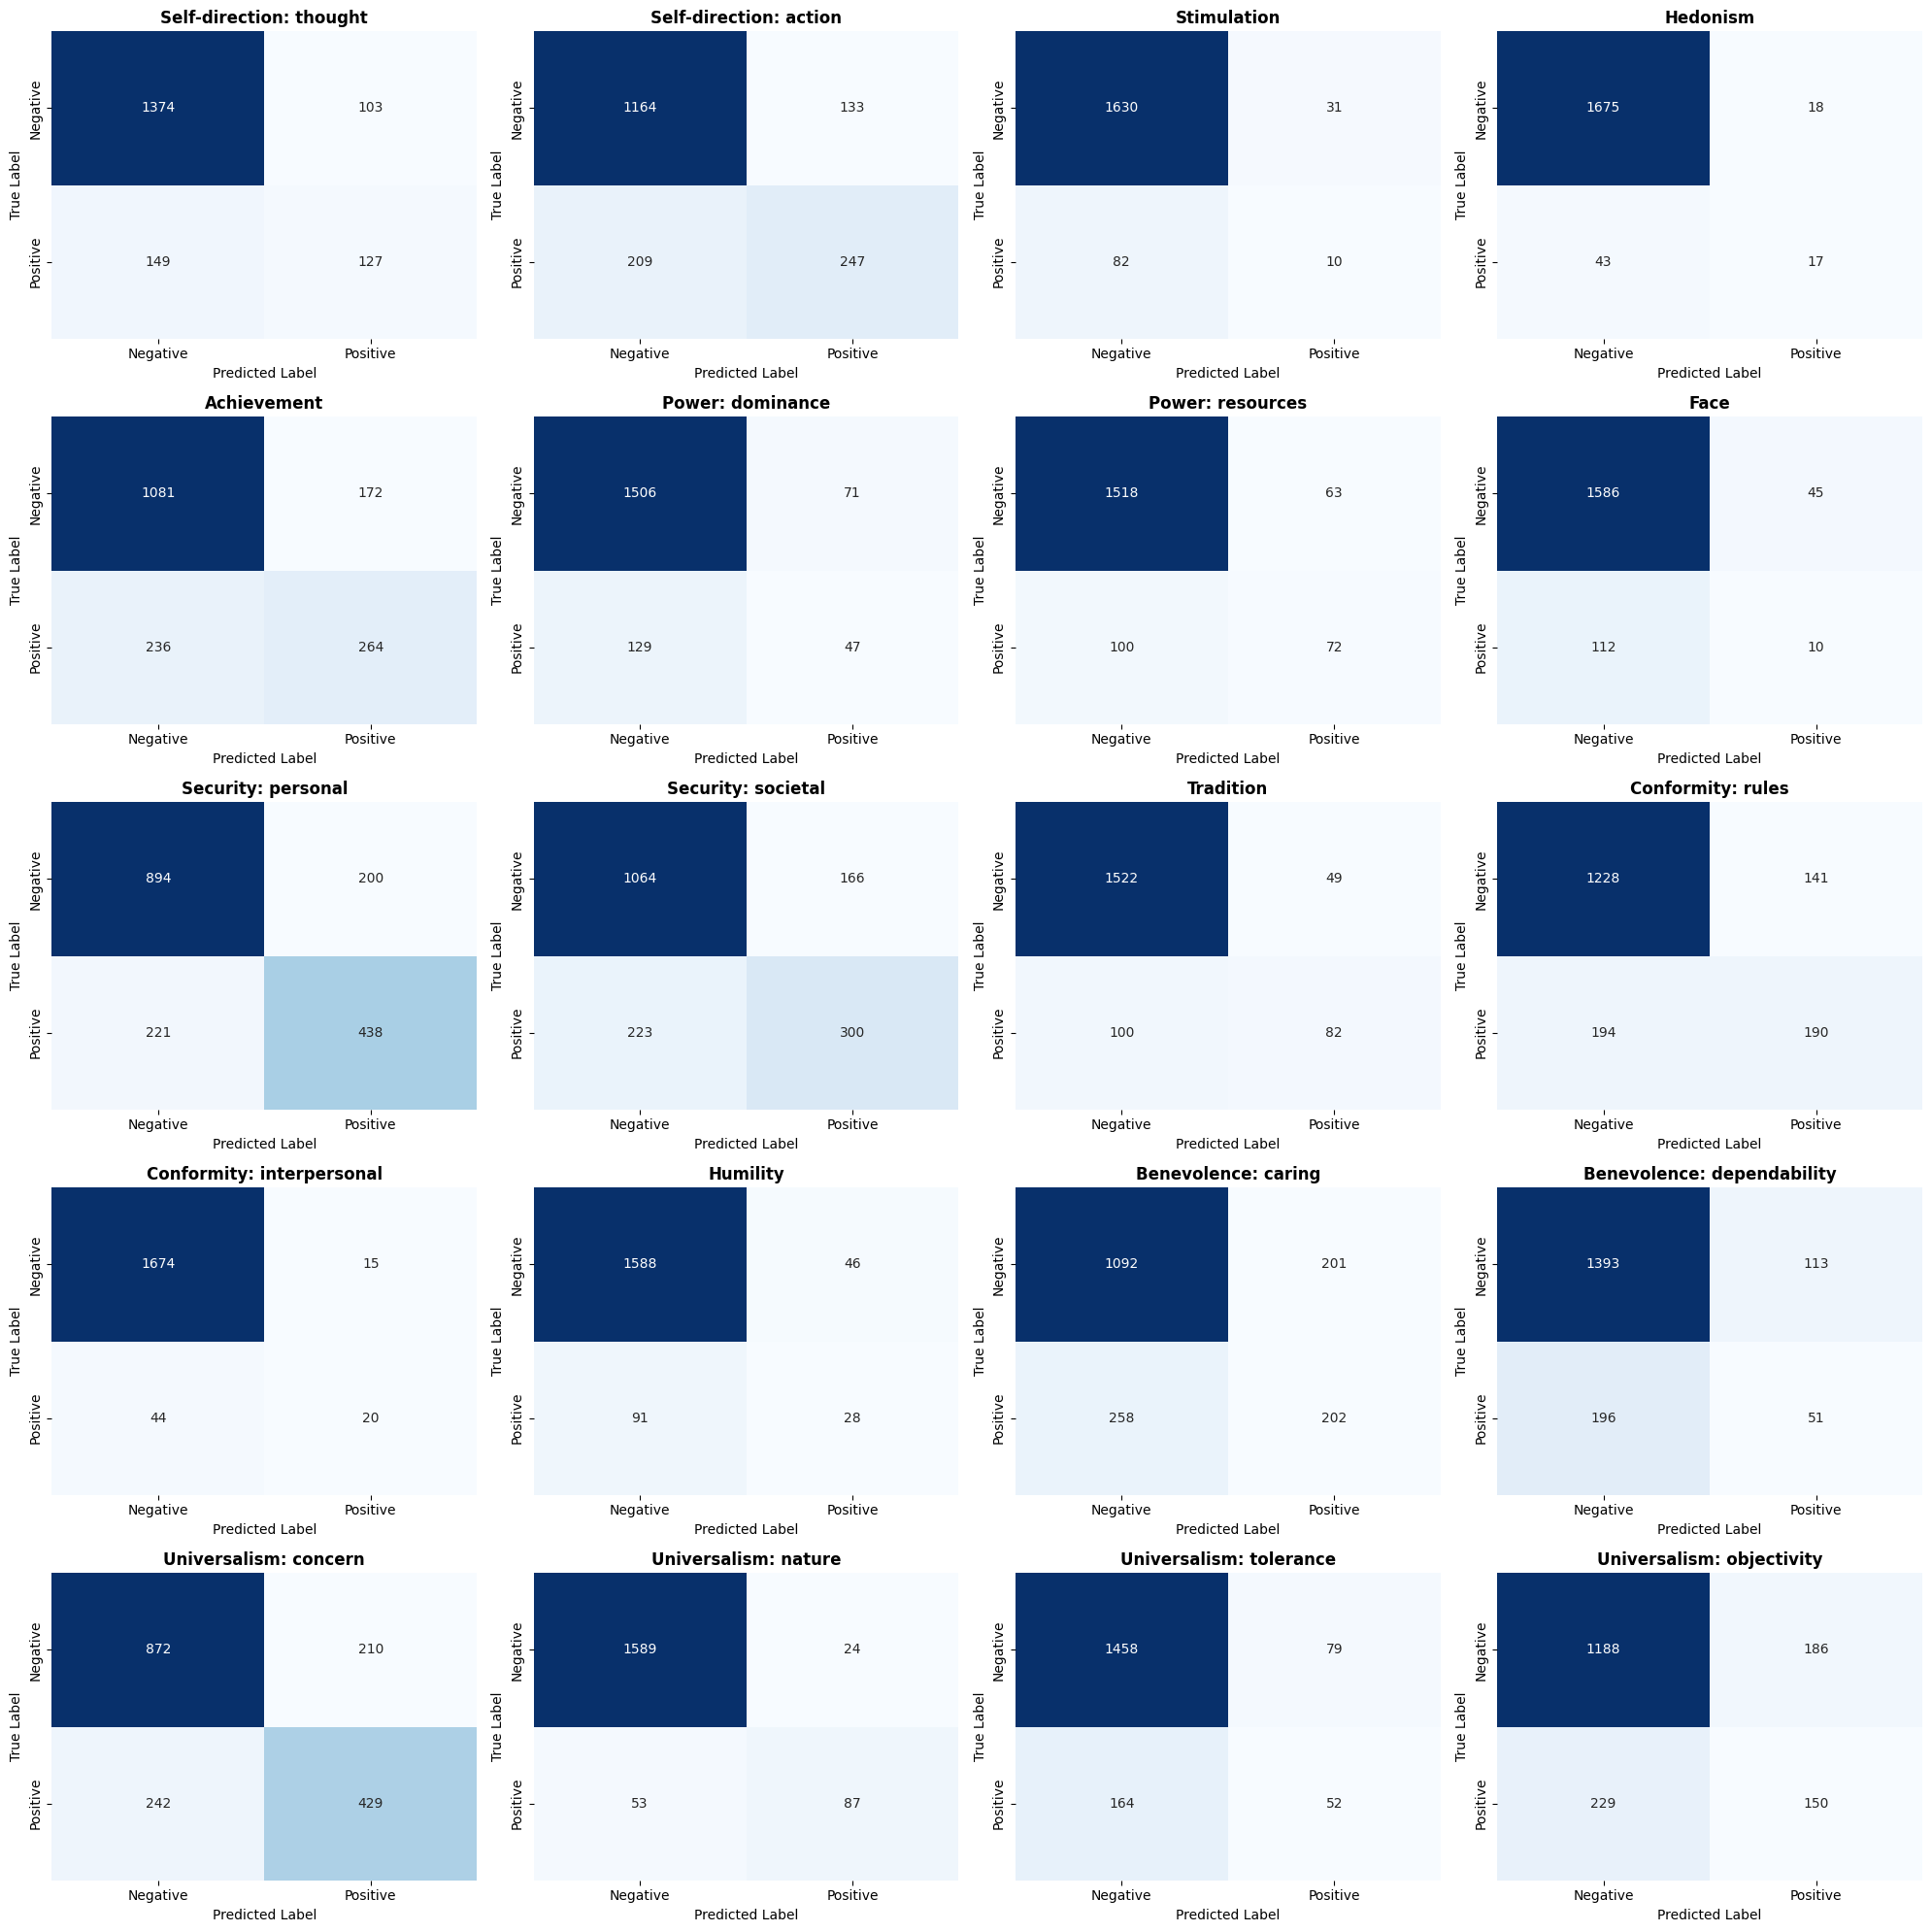

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import multilabel_confusion_matrix

# 1. Generate predictions on the test set
print("Generating predictions on the test set...")
y_pred = grid_search.predict(X_test_lemmatized)

# 2. Calculate the multi-label confusion matrix (20 matrices of 2x2)
mcm = multilabel_confusion_matrix(y_test, y_pred)

# 3. EXTRAER LOS NOMBRES DE LAS VARIABLES (Ignorando 'Argument ID')
# Usamos las columnas de train_labels pero filtramos el ID
class_names = [col for col in train_labels.columns if col != 'Argument ID']

# 4. Configure the plot layout
num_classes = len(class_names)
cols = 4  # Ponemos 4 columnas para que quepan mejor las 20 clases (5 filas x 4 columnas)
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten() 

# 5. Plot each 2x2 matrix
for i, (matrix, name) in enumerate(zip(mcm, class_names)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'],
                cbar=False)
    
    # Título con el nombre real del valor (ej. "Hedonism")
    axes[i].set_title(f'{name}', fontweight='bold', fontsize=12)
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

# Ocultar los gráficos vacíos si sobran cuadrículas
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 4.2 Discriminative Features

In [14]:
import numpy as np

# 1. Extraer los componentes del pipeline
mejor_pipeline = grid_search.best_estimator_
vectorizador = mejor_pipeline.named_steps['vec']
modelo_ovr = mejor_pipeline.named_steps['clf']

# 2. Obtener el vocabulario y los modelos
nombres_features = vectorizador.get_feature_names_out()
clasificadores = modelo_ovr.estimators_

# 3. Nombres de tus clases
class_names = [col for col in train_labels.columns if col != 'Argument ID']

# --- NUEVO: DIAGNÓSTICO DE TAMAÑOS ---
print("⚙️ DIAGNÓSTICO DEL MODELO:")
print(f" - Número de nombres de variables: {len(class_names)}")
print(f" - Número de modelos entrenados: {len(clasificadores)}")
print("=" * 70)
# ------------------------------------

print("\n🔍 EXTRACCIÓN DE DISCRIMINATIVE FEATURES (TOP 10 N-GRAMAS)")

# 4. Bucle seguro (iteramos solo hasta el número real de clasificadores que existen)
for i in range(len(clasificadores)):
    
    # Asignamos el nombre de forma segura
    if i < len(class_names):
        nombre_clase = class_names[i]
    else:
        # Por si hay más clasificadores que nombres (muy raro)
        nombre_clase = f"Clase_Desconocida_{i}"
        
    # Extraer los coeficientes matemáticos de la clase actual
    coeficientes = clasificadores[i].coef_[0]
    
    # Obtener los índices de las palabras ordenados por su peso
    indices_ordenados = np.argsort(coeficientes)
    
    # Extraer los top n-gramas usando los índices
    top_negativos = [nombres_features[idx] for idx in indices_ordenados[:10]]
    top_positivos = [nombres_features[idx] for idx in indices_ordenados[-10:]][::-1]
    
    print(f"\n🏆 CLASE: {nombre_clase}")
    print(f"  🟢 A FAVOR (+): {', '.join(top_positivos)}")
    print(f"  🔴 EN CONTRA (-): {', '.join(top_negativos)}")

⚙️ DIAGNÓSTICO DEL MODELO:
 - Número de nombres de variables: 20
 - Número de modelos entrenados: 20

🔍 EXTRACCIÓN DE DISCRIMINATIVE FEATURES (TOP 10 N-GRAMAS)

🏆 CLASE: Self-direction: thought
  🟢 A FAVOR (+): innovation, obsolete, served, would like, favor make, space used, reporting, subsidization, decision making, internet
  🔴 EN CONTRA (-): destroy, sort, offence favor, criminal offence favor, worth, foster, right freedom, small, respected, people already

🏆 CLASE: Self-direction: action
  🟢 A FAVOR (+): independent, choice, dream, freedom, corruption, people looking, independence, push, suppression, misused
  🔴 EN CONTRA (-): practical, surgery favor, cosmetic surgery favor, offence favor, criminal offence favor, banned favor, knowing, form freedom, surgery minor favor, minor favor

🏆 CLASE: Stimulation
  🟢 A FAVOR (+): productive, independent, hurt people, treating, anyway, everyone right, places, shooting, favor legal, chance get
  🔴 EN CONTRA (-): information, government, know

## 4.3 Qualitative Failure Analysis

Qualitative Failure Analysis: Manual categorization of at least 5 specific misclassified examples (e.g., sarcasm, negation failure, ambiguity).

In [15]:
import numpy as np

# 1. Encontrar índices donde hay AL MENOS UN ERROR (Falso Positivo o Falso Negativo)
# Comparamos fila por fila y_test contra y_pred
errores_idx = np.where(np.any(y_test != y_pred, axis=1))[0]

print(f"Total de textos con al menos un error: {len(errores_idx)}")
print("Mostrando 5 ejemplos de fallos para tu Qualitative Analysis:\n")

# 2. Escoger 5 índices al azar (usamos semilla para que siempre salgan los mismos)
np.random.seed(42) 
ejemplos_mostrar = np.random.choice(errores_idx, 5, replace=False)

# 3. Imprimir los textos originales y el fallo
for i, idx in enumerate(ejemplos_mostrar):
    # Cogemos el texto original (sin lematizar) para que sea legible
    texto_original = X_test[idx]
    
    # Etiquetas que anotaron los humanos (Ground Truth)
    real_labels = [class_names[j] for j, val in enumerate(y_test[idx]) if val == 1]
    
    # Etiquetas que predijo tu modelo
    pred_labels = [class_names[j] for j, val in enumerate(y_pred[idx]) if val == 1]
    
    print("=" * 80)
    print(f"❌ EJEMPLO DE FALLO #{i+1}")
    print("-" * 80)
    print(f"📝 TEXTO ORIGINAL:\n{texto_original}\n")
    
    # Mostramos qué debía predecir vs qué predijo en realidad
    print(f"🧠 VALORES REALES (Anotadores): {real_labels if real_labels else 'Ninguno'}")
    print(f"🤖 VALORES PREDICHOS (Modelo):  {pred_labels if pred_labels else 'Ninguno'}")
    print("=" * 80 + "\n")

Total de textos con al menos un error: 1668
Mostrando 5 ejemplos de fallos para tu Qualitative Analysis:

❌ EJEMPLO DE FALLO #1
--------------------------------------------------------------------------------
📝 TEXTO ORIGINAL:
Esperanto should replace English as the first foreign language in schools and universities in favor of To build a common European understanding and to create a European identity, we need our own common language. 

🧠 VALORES REALES (Anotadores): ['Achievement', 'Power: dominance', 'Face', 'Security: personal', 'Security: societal']
🤖 VALORES PREDICHOS (Modelo):  ['Self-direction: action', 'Achievement', 'Security: personal']

❌ EJEMPLO DE FALLO #2
--------------------------------------------------------------------------------
📝 TEXTO ORIGINAL:
Surrogacy should be banned in favor of a surrogate carrying a baby could try to keep it since they gave birth to it.

🧠 VALORES REALES (Anotadores): ['Conformity: rules', 'Benevolence: caring']
🤖 VALORES PREDICHOS (Modelo):